In [171]:
import pandas as pd
import glob
import collections
from collections import Counter
import time
from datetime import timedelta
import csv
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from datetime import datetime
import statistics

In [2]:
path1 = "../Desktop/raw_kickstarter_data/"
path2 = "../Desktop/cleaned_kickstarter_data/"
count = 0
for foldername in glob.glob(path1 + "*"):
    print(foldername)
    # import data
    frames = []
    for filename in glob.glob(foldername + "/*.csv"):
        if count == 0:
            df = pd.read_csv(filename)
            count += 1
        else:
            df = pd.read_csv(filename, header = 0)
        frames.append(df)

../Desktop/raw_kickstarter_data/2017-10
../Desktop/raw_kickstarter_data/2018-05
../Desktop/raw_kickstarter_data/2018-02
../Desktop/raw_kickstarter_data/2017-11
../Desktop/raw_kickstarter_data/2018-03
../Desktop/raw_kickstarter_data/2018-04
../Desktop/raw_kickstarter_data/2016-11
../Desktop/raw_kickstarter_data/2019-03
../Desktop/raw_kickstarter_data/2019-04
../Desktop/raw_kickstarter_data/2016-10
../Desktop/raw_kickstarter_data/2019-02
../Desktop/raw_kickstarter_data/2016-04
../Desktop/raw_kickstarter_data/2016-03
../Desktop/raw_kickstarter_data/2016-05
../Desktop/raw_kickstarter_data/2018-10
../Desktop/raw_kickstarter_data/2017-02
../Desktop/raw_kickstarter_data/2017-05
../Desktop/raw_kickstarter_data/2018-11
../Desktop/raw_kickstarter_data/2017-04
../Desktop/raw_kickstarter_data/2017-03
../Desktop/raw_kickstarter_data/2018-08
../Desktop/raw_kickstarter_data/2018-01
../Desktop/raw_kickstarter_data/2018-06
../Desktop/raw_kickstarter_data/2018-07
../Desktop/raw_kickstarter_data/2018-09


In [18]:
### INITIAL DATA CLEANING

projects_id = []
df1 = pd.DataFrame()
df1_success = pd.DataFrame()
df1_fail = pd.DataFrame()

# 2016-2019 data
df1 = pd.concat(frames, axis = 0, join = 'inner')

# remove unnecessary columns
to_drop = ['blurb','currency','currency_symbol','disable_communication','launched_at',
           'location','photo','pledged','profile','slug','spotlight','staff_pick',
           'state_changed_at','static_usd_rate']
df1.drop(to_drop, inplace=True, axis=1)

category_id1 = []
creator_id1 = []
category_name1 = []
url1 = []

# extract category id
for c1 in df1['category']:
    start_idx = c1.find('"id":') + 5
    end_idx1 = c1.find('"position":') - 1
    end_idx2 = c1.find('"name":') - 1
    end_idx = 0
    if (start_idx < end_idx1 and start_idx < end_idx2):
        end_idx = min(end_idx1, end_idx2)
    else:
        end_idx = max(end_idx1, end_idx2)
    category_id1.append(c1[start_idx:end_idx])

# extract creator id
for c2 in df1['creator']:
    start_idx = c2.find('"id":') + 5
    end_idx1 = c2.find('"avatar":') - 1
    end_idx2 = c2.find('"name":') - 1
    end_idx = 0
    if (start_idx < end_idx1 and start_idx < end_idx2):
        end_idx = min(end_idx1, end_idx2)
    else:
        end_idx = max(end_idx1, end_idx2)
    creator_id1.append(c2[start_idx:end_idx])

# extract category name
for c3 in df1['category']:
    start_idx = c3.find('"slug":') + 8
    end_idx = c3.find('"position":') - 2
    category_name1.append(c3[start_idx:end_idx])

# extract project url
for u1 in df1['urls']:
    start_idx = u1.find('"project":"') + 11
    end_idx = u1.find('"rewards":') - 2
    url1.append(u1[start_idx:end_idx])

# define new columns
df1['category_id'] = category_id1
df1['creator_id'] = creator_id1
df1['category_name'] = category_name1
df1['url'] = url1

# rearranging columns
df1 = df1[['creator_id','id','name','created_at','deadline','category_id','category_name',
           'goal','usd_pledged','backers_count','state','url', 'country']]

# convert epoch to datetime
df1['created_at'] = pd.to_datetime(df1['created_at'],unit='s')
df1['deadline'] = pd.to_datetime(df1['deadline'],unit='s')

# only keep US companies that were not cancelled
df1 = df1.loc[(df1['country'] == 'US') & (df1['state'].isin(['successful','failed'])) & 
                  (df1['goal'] > 25000) & (df1['usd_pledged'] > 2500)]
df1_success = df1.loc[(df1['country'] == 'US') & (df1['state'] == 'successful') & 
                      (df1['goal'] > 25000) & (df1['usd_pledged'] > 2500)]
df1_fail = df1.loc[(df1['country'] == 'US') & (df1['state'] == 'failed') & 
                       (df1['goal'] > 25000)& (df1['usd_pledged'] > 2500)]
df1.drop(['country'], inplace = True, axis = 1)
df1_success.drop(['country'], inplace = True, axis = 1)
df1_fail.drop(['country'], inplace = True, axis = 1)

# remove duplicates
df1 = df1.drop_duplicates('id')
projects_id = projects_id + list(df1['id'])
df1_success = df1_success.drop_duplicates('id')
df1_fail = df1_fail.drop_duplicates('id')

/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [39]:
# first sort by category id, then sort by date
df1.sort_values(['deadline'], ascending = True, inplace = True)
df1_success.sort_values(['deadline'], ascending = True, inplace = True)
df1_fail.sort_values(['deadline'], ascending = True, inplace = True)

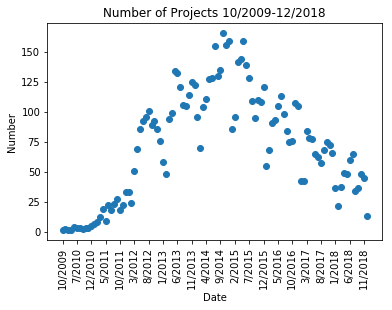

In [230]:
df2 = df1.copy()
df2['Month/Year'] = df2['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))
df3 = df2.groupby(['Month/Year']).size().to_dict()

ordered_df3 = sorted(df3.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)

plt.scatter(*zip(*ordered_df3))
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation='vertical') 
plt.xlabel('Date')
plt.ylabel('Number')
plt.title('Number of Projects 10/2009-12/2018')
plt.show()

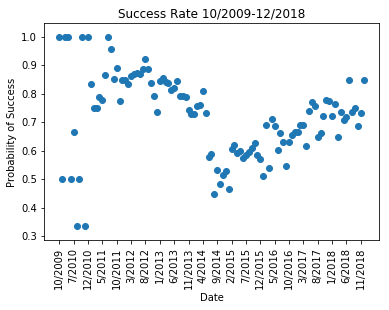

In [231]:
df2_success = df1_success.copy()
df2_success['Month/Year'] = df2_success['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))
df3_success = df2_success.groupby(['Month/Year']).size().to_dict()

ordered_df3_success = sorted(df3_success.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)

ordered_df3_success_rate = []
for i in range(len(ordered_df3_success)):
    lst = list(ordered_df3_success[i])
    lst[1] = ordered_df3_success[i][1] / ordered_df3[i][1]
    ordered_df3_success_rate.append(tuple(lst))

plt.scatter(*zip(*ordered_df3_success_rate))
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation='vertical')
plt.xlabel('Date')
plt.ylabel('Probability of Success')
plt.title('Success Rate 10/2009-12/2018')
plt.show()

In [232]:
print(len(ordered_df3))
print(len(ordered_df3_success))

107
107


/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


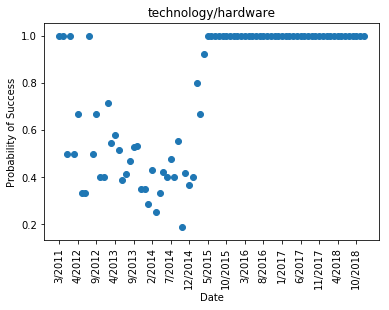

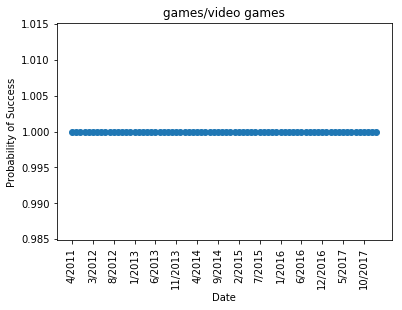

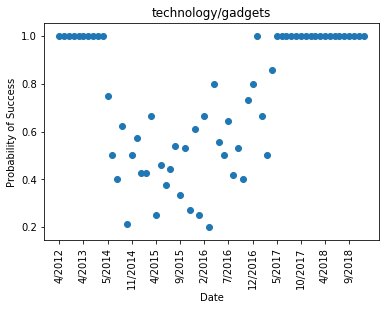

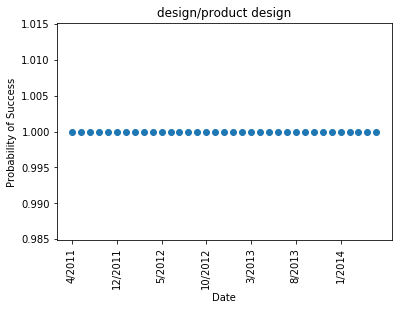

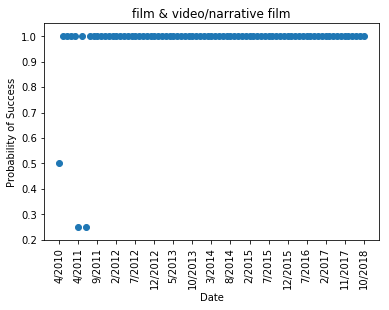

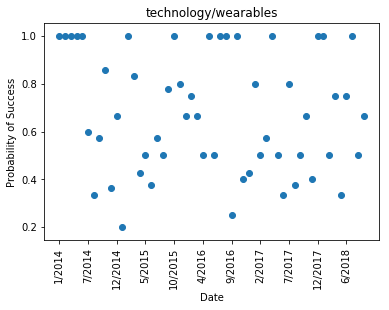

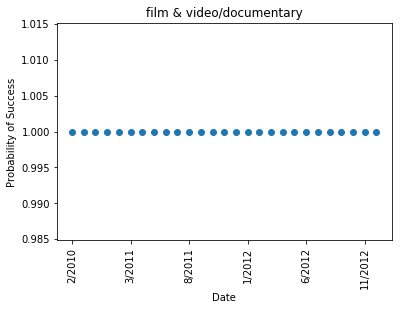

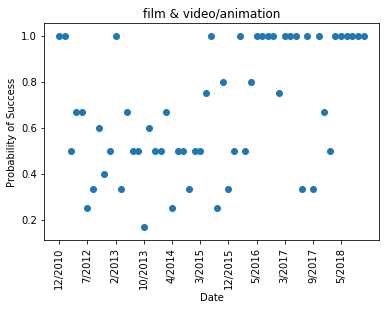

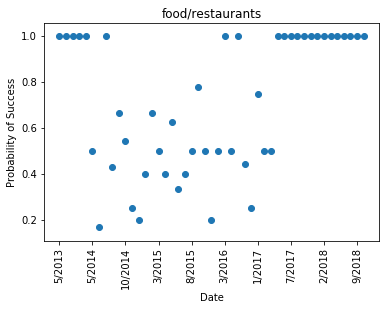

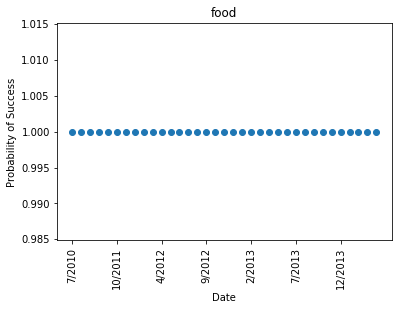

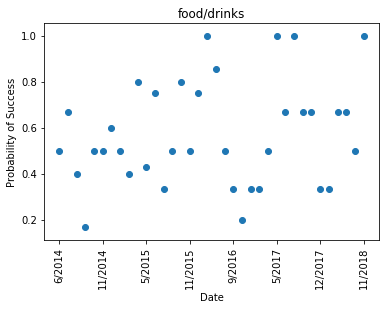

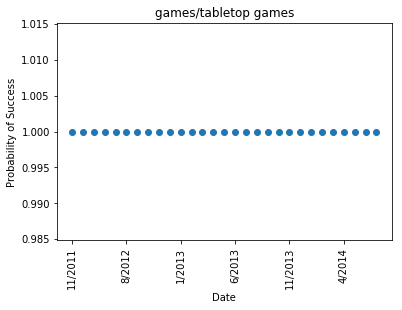

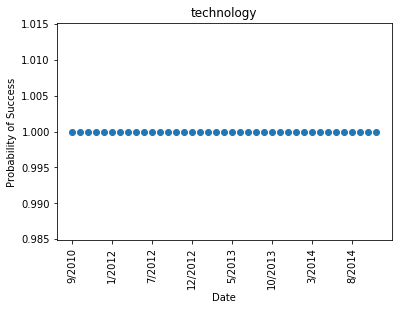

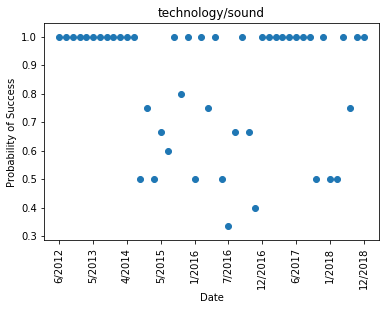

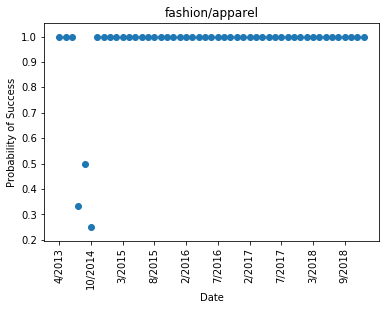

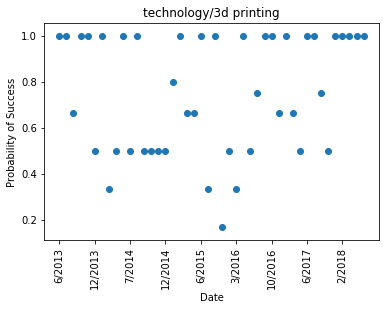

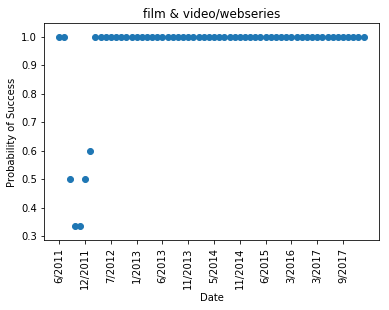

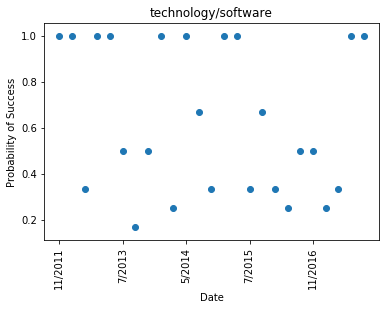

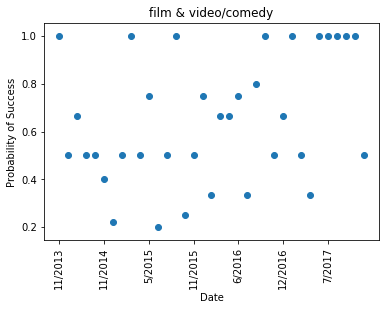

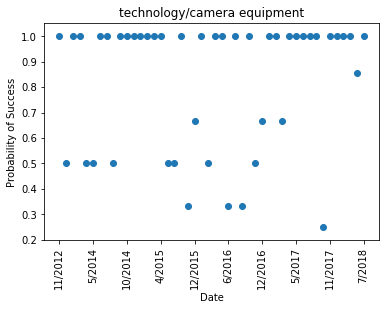

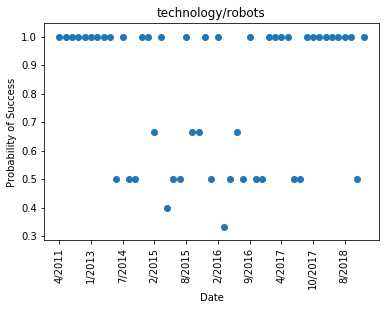

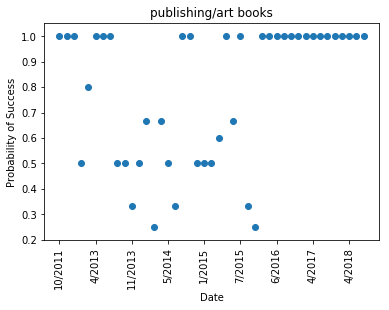

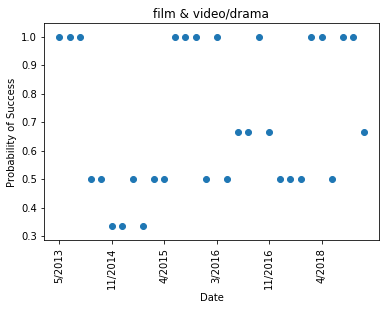

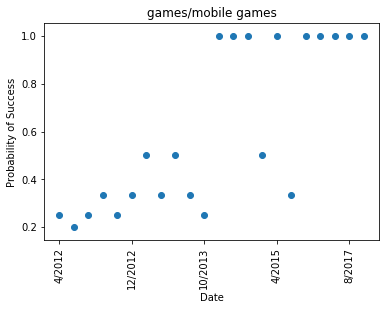

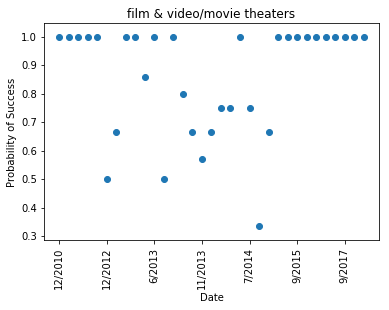

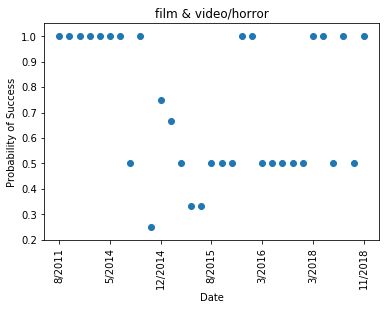

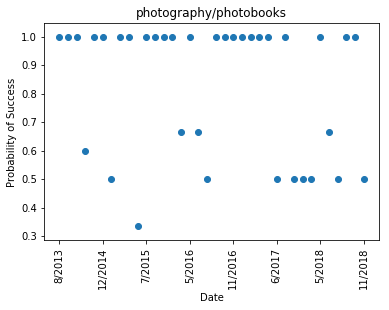

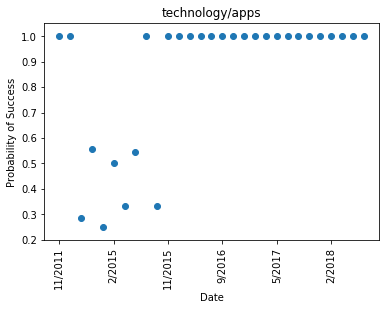

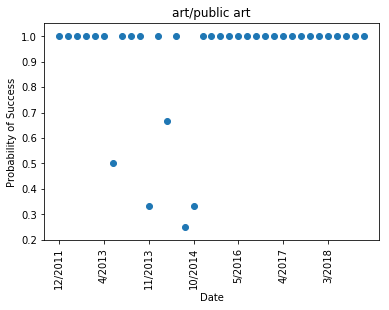

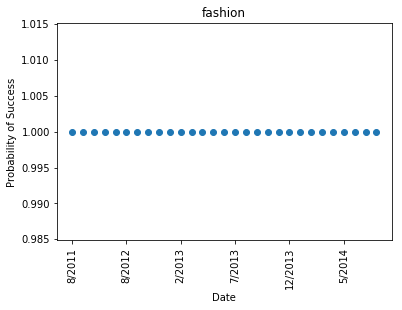

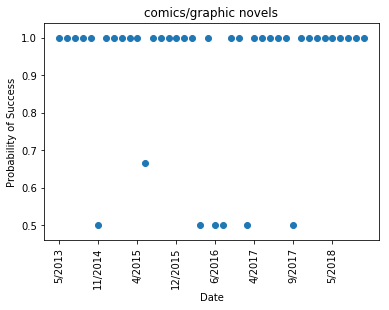

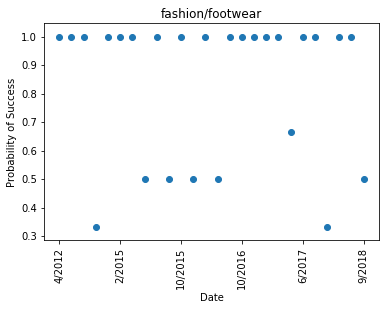

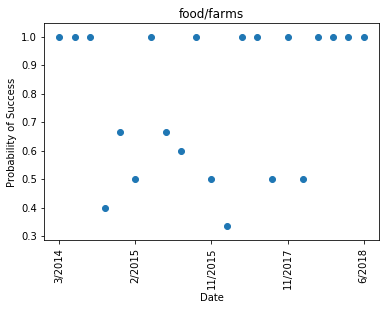

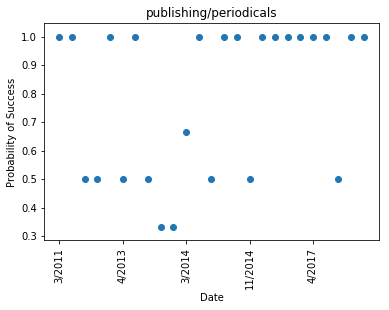

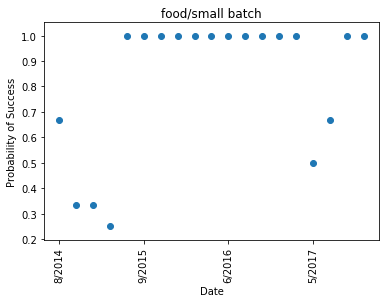

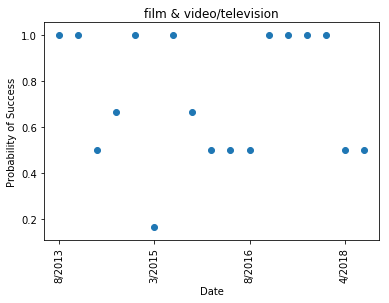

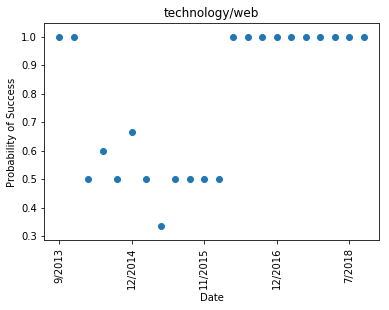

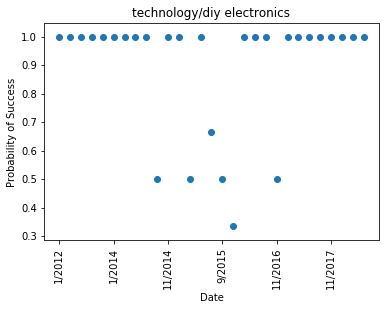

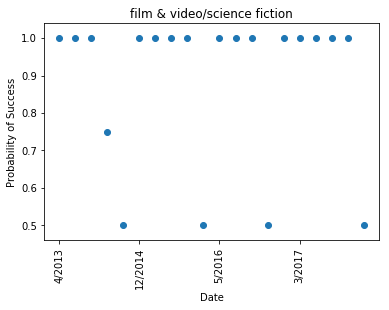

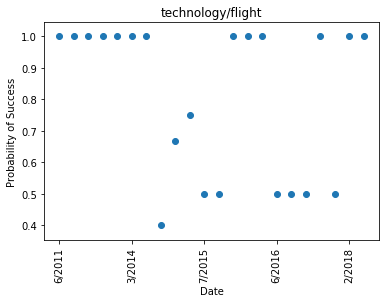

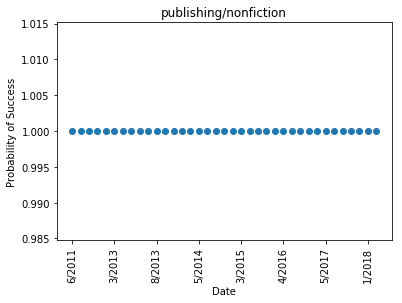

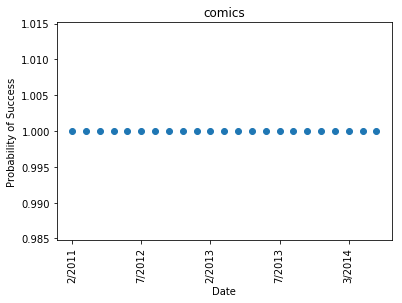

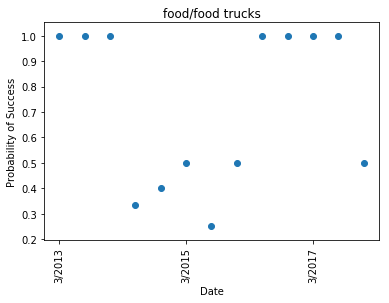

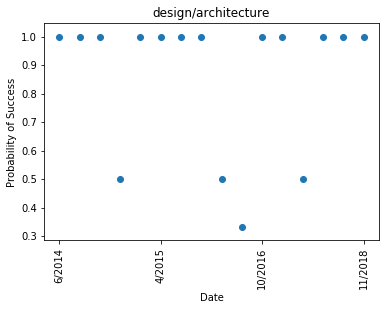

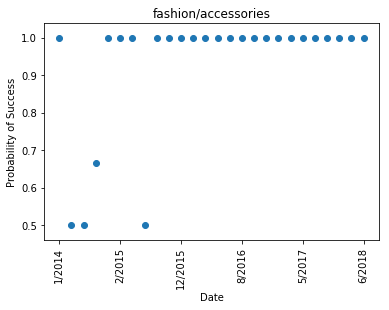

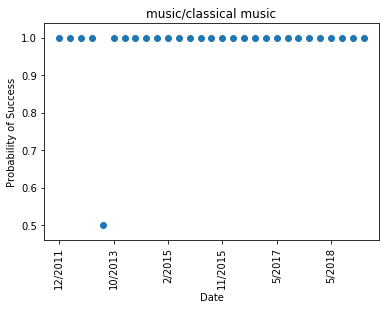

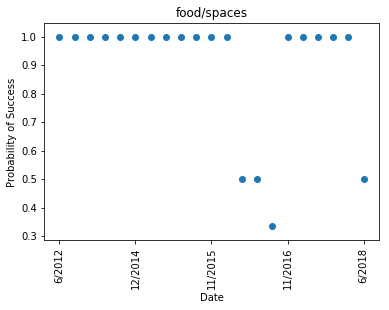

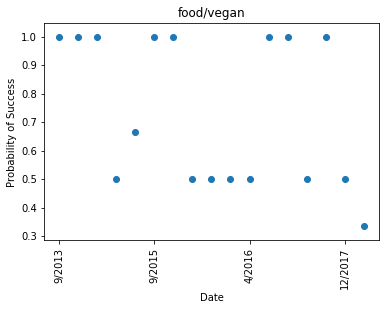

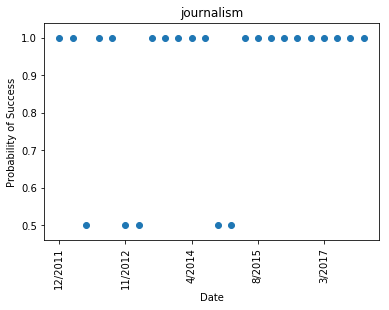

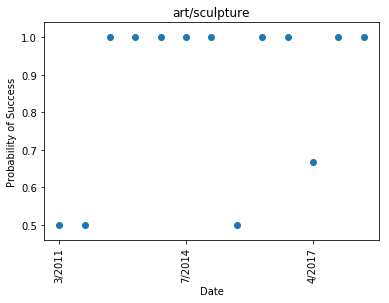

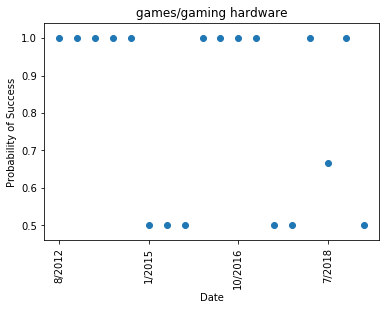

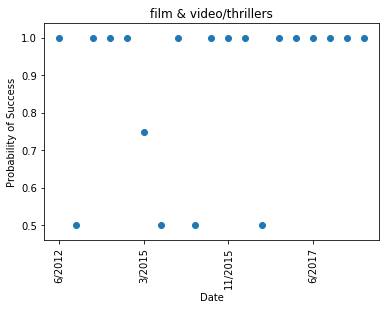

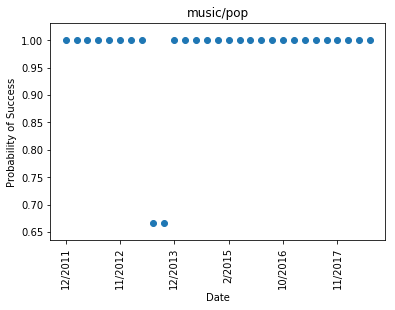

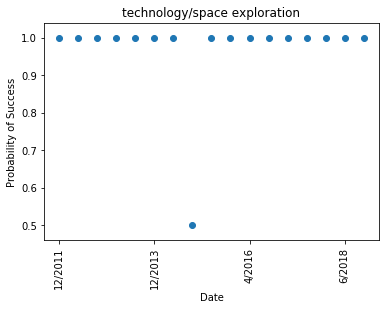

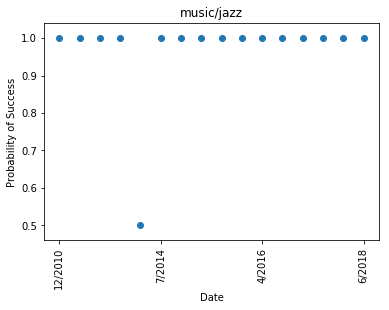

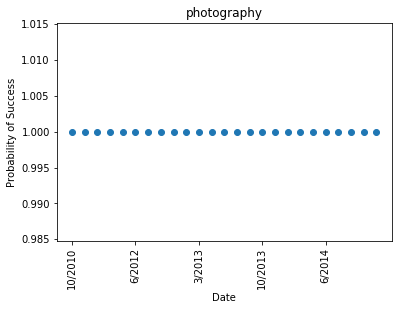

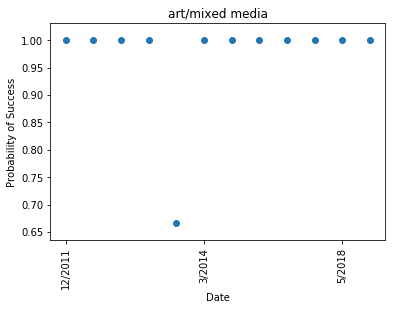

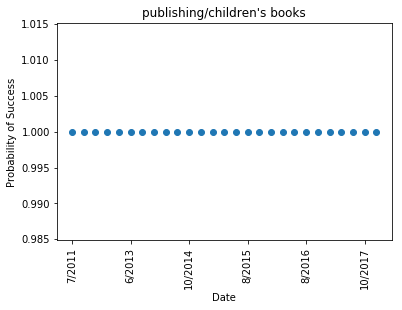

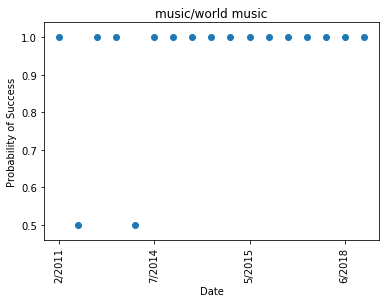

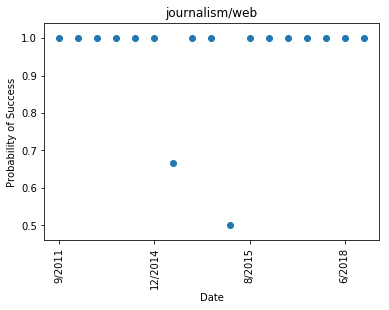

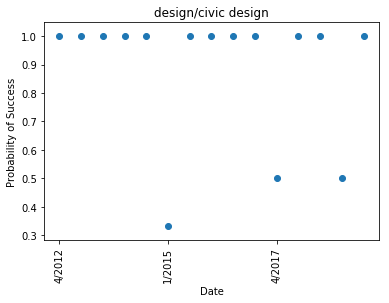

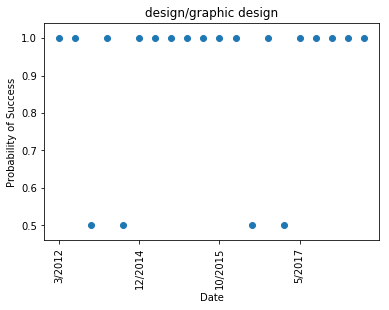

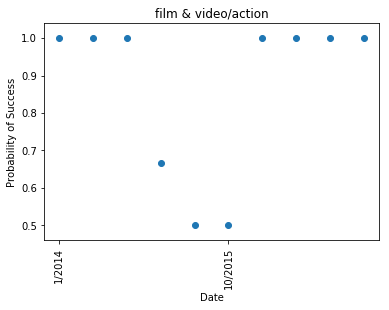

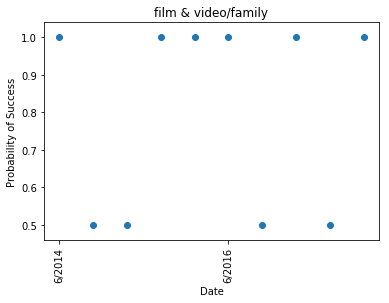

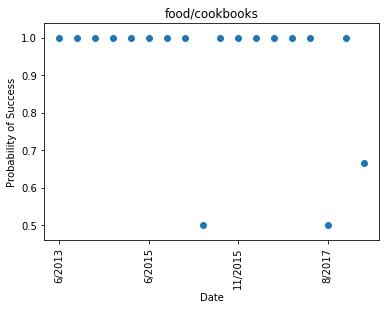

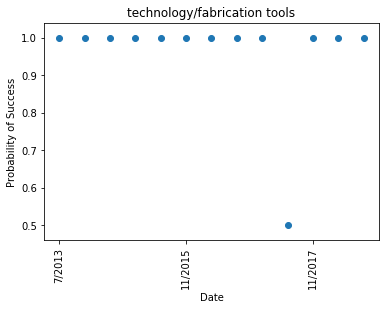

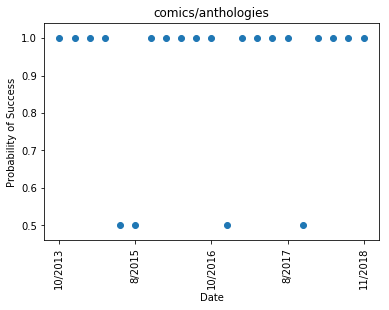

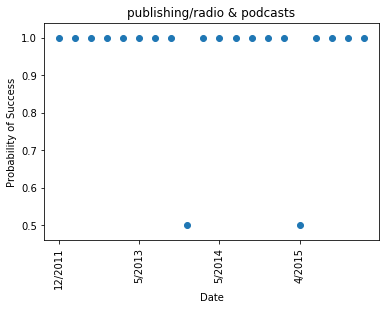

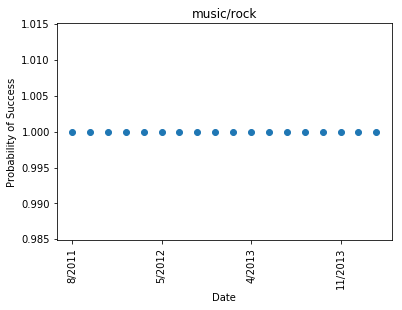

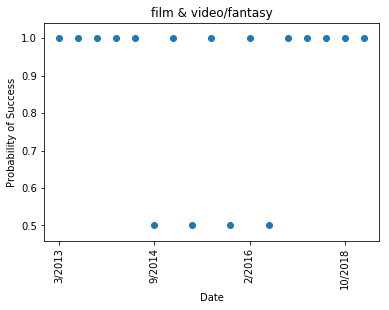

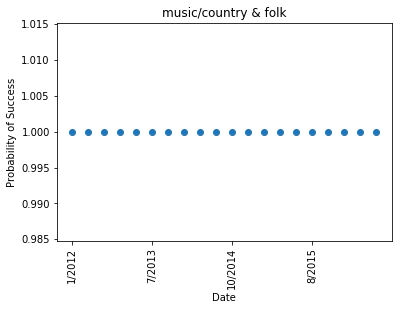

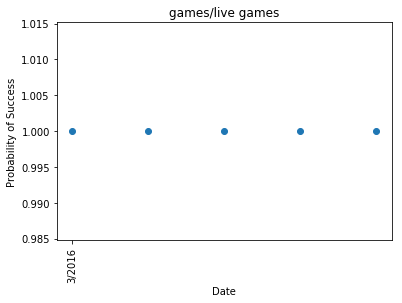

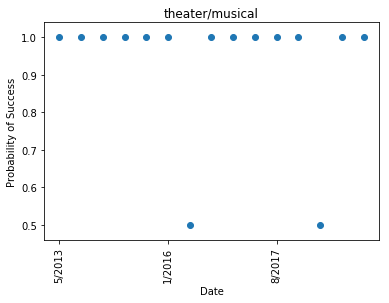

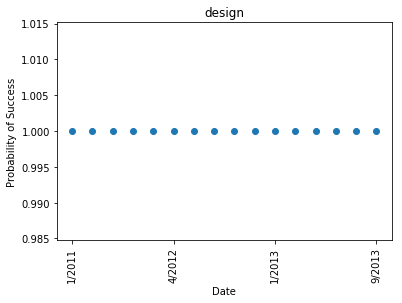

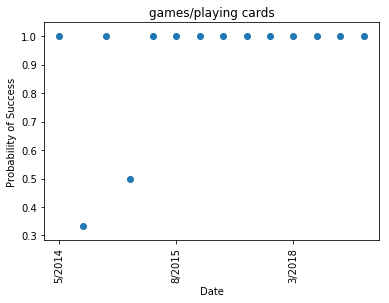

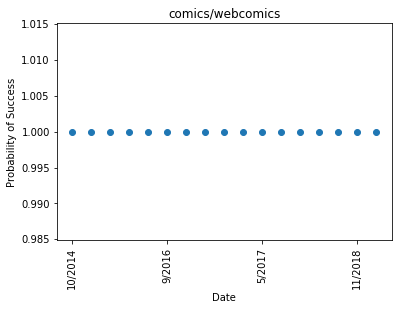

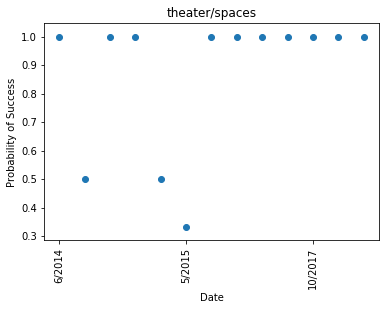

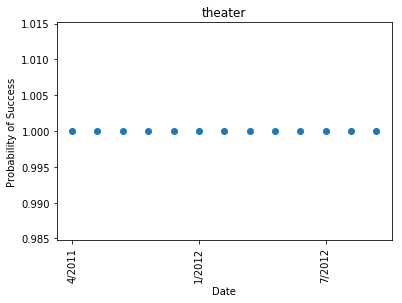

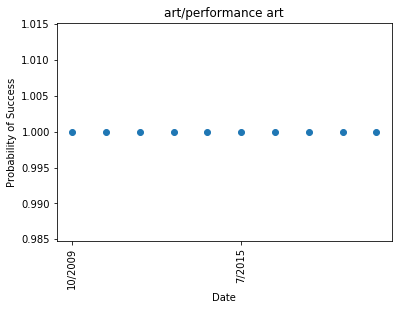

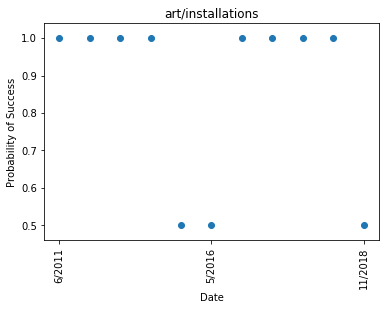

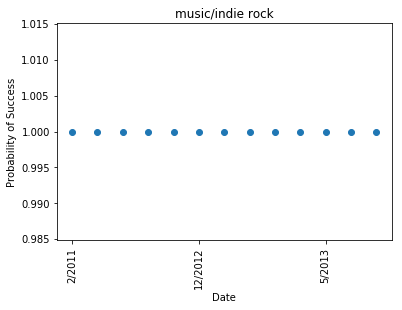

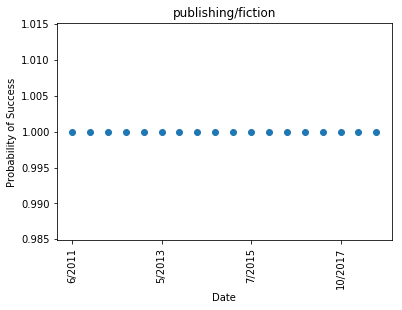

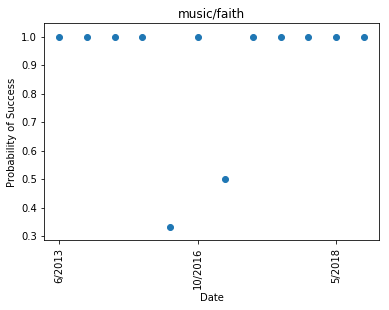

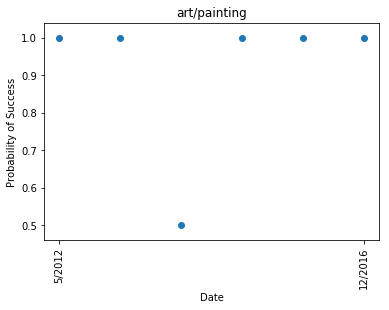

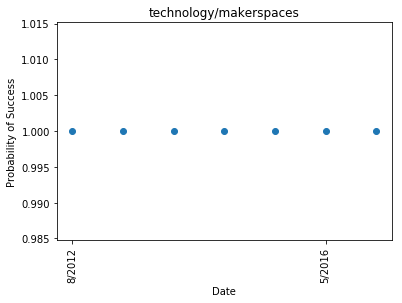

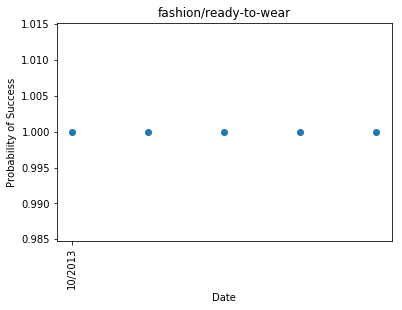

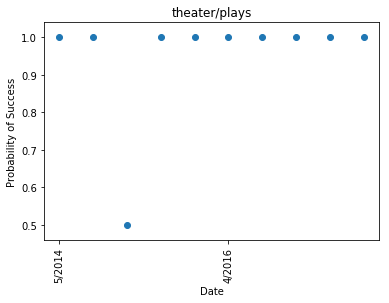

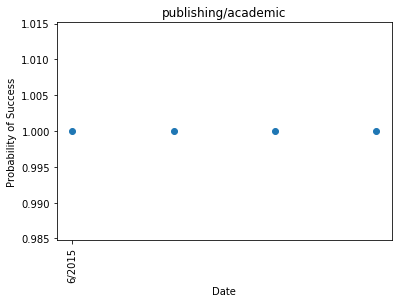

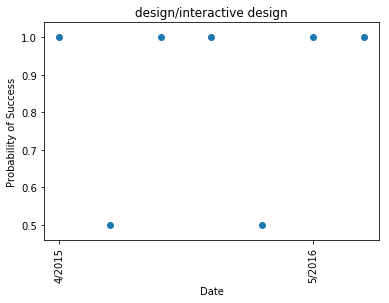

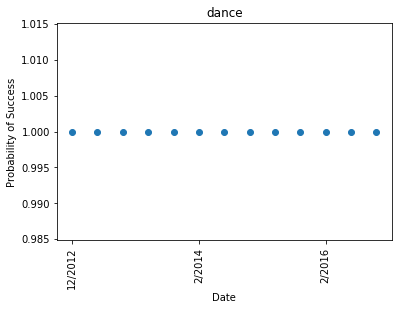

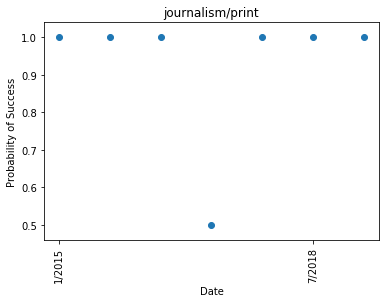

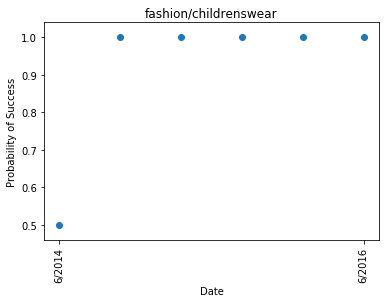

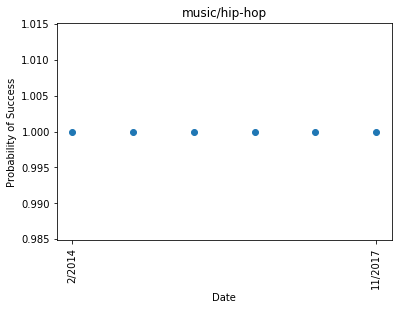

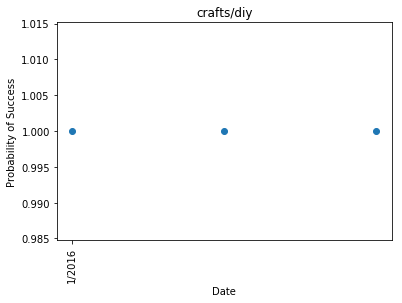

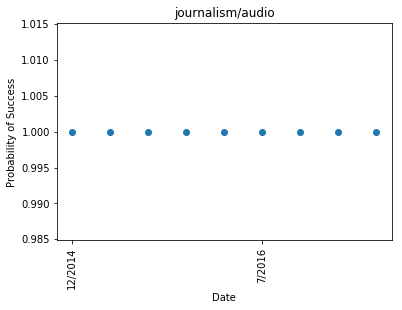

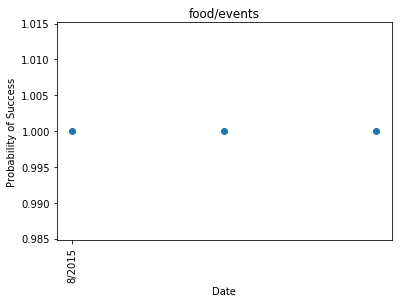

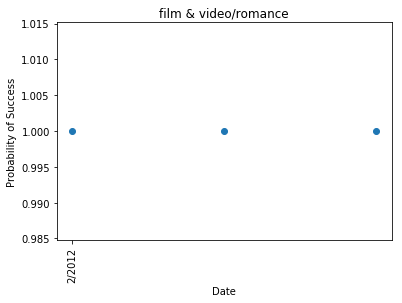

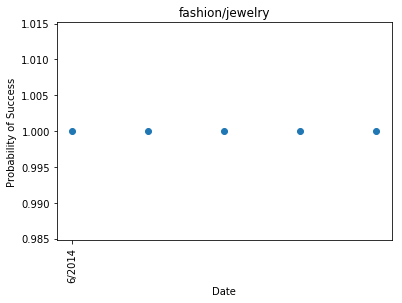

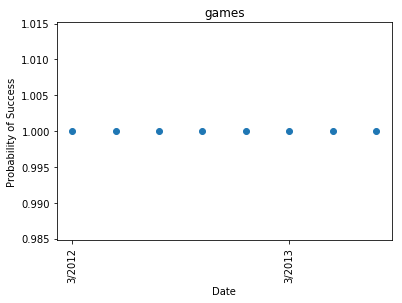

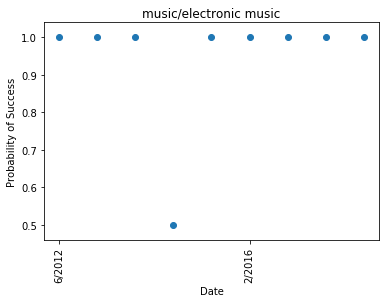

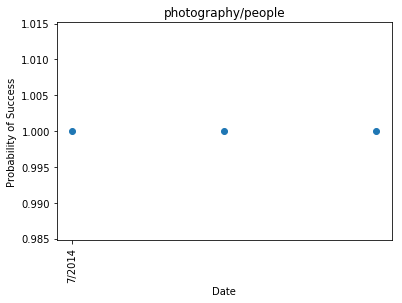

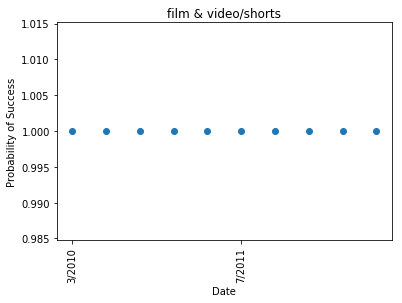

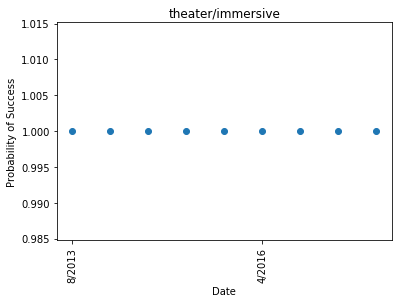

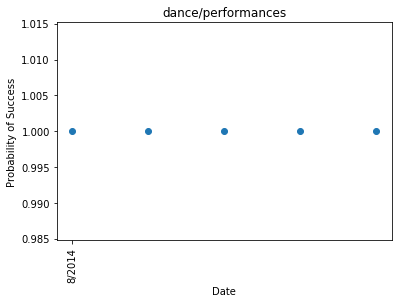

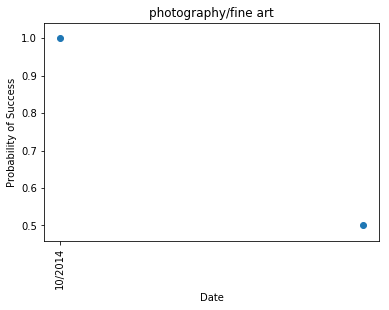

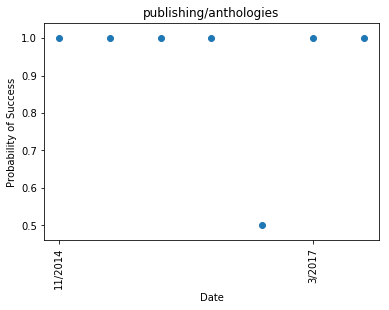

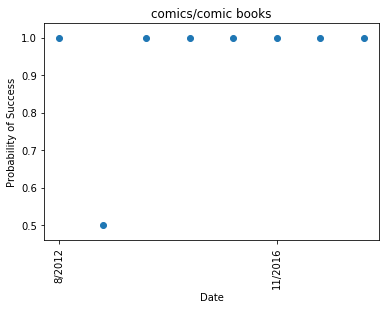

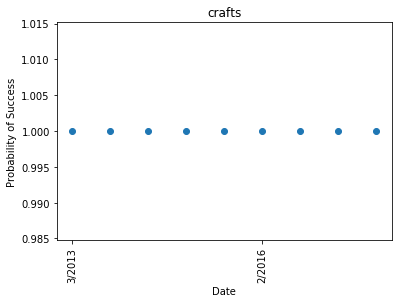

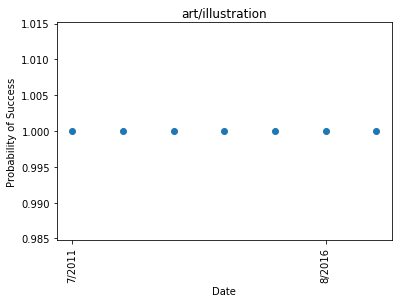

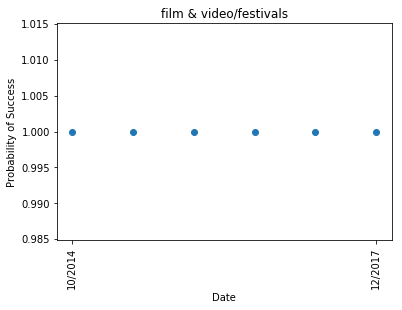

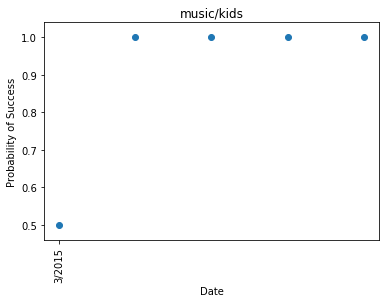

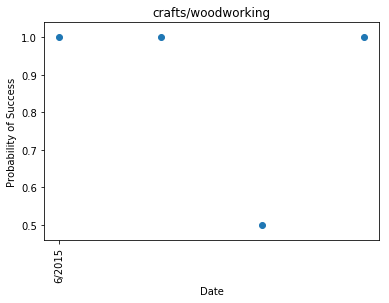

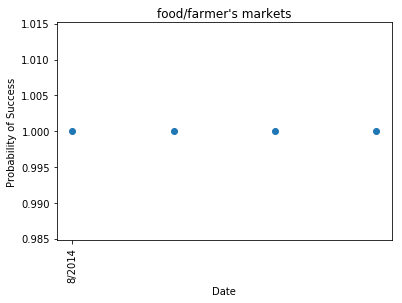

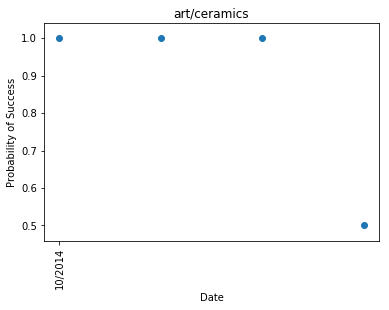

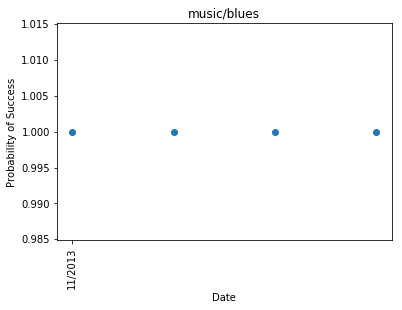

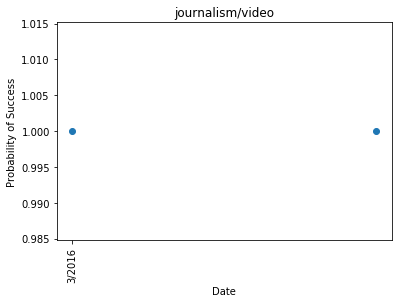

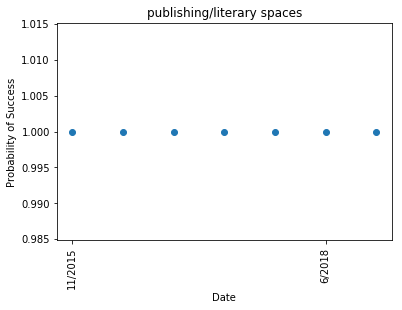

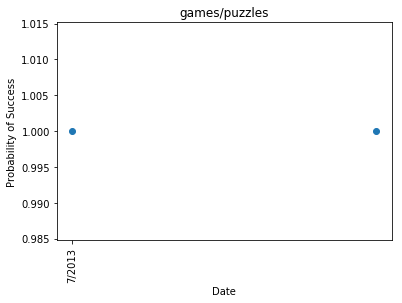

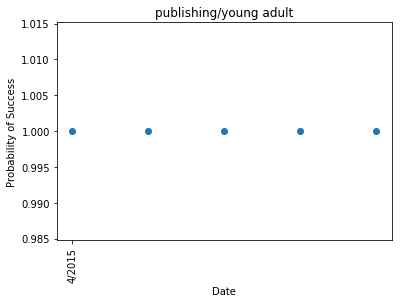

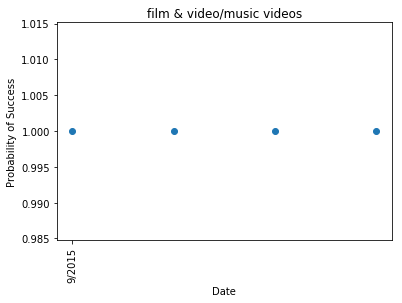

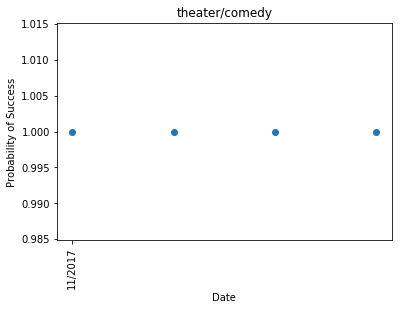

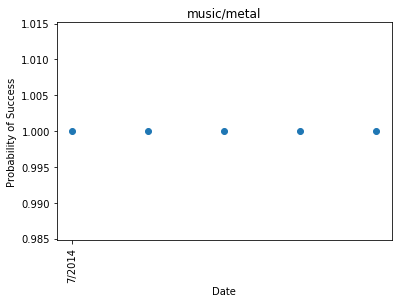

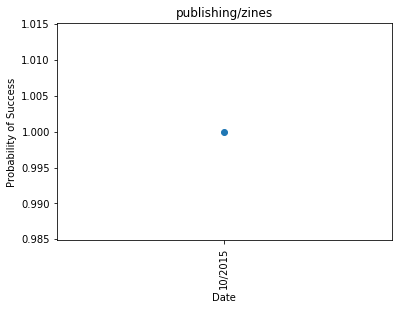

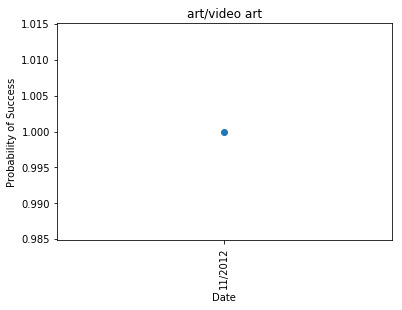

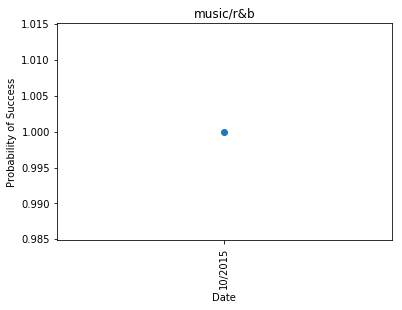

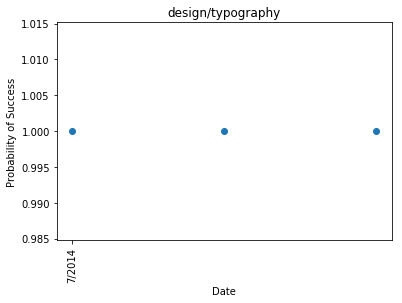

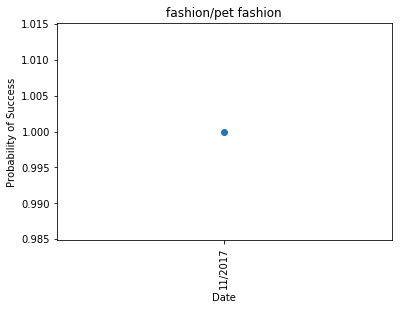

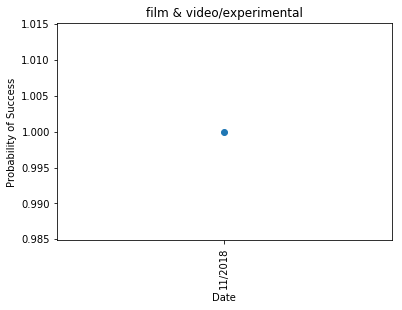

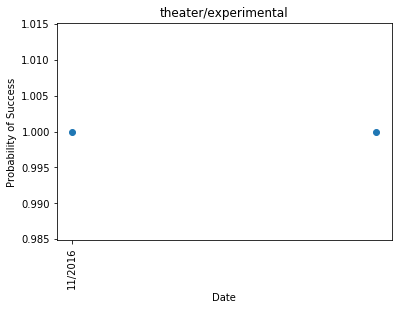

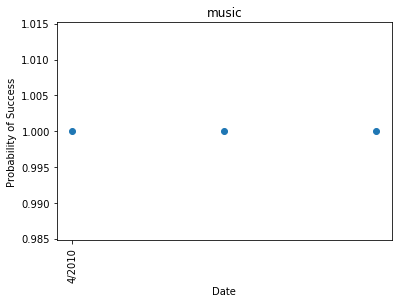

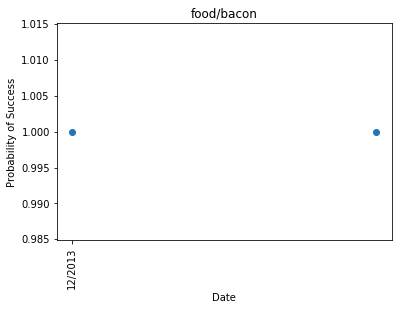

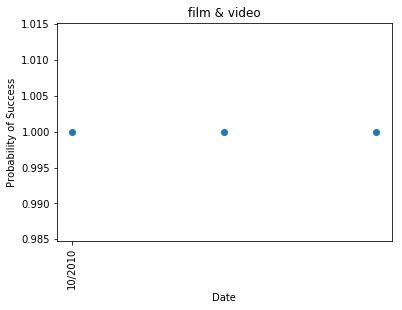

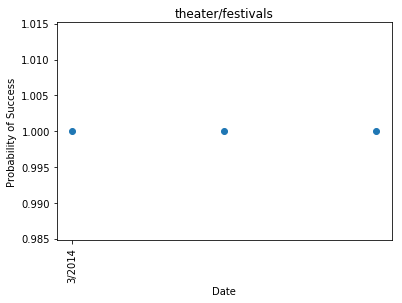

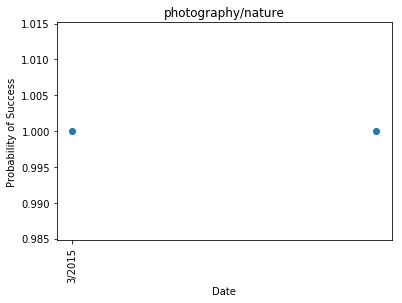

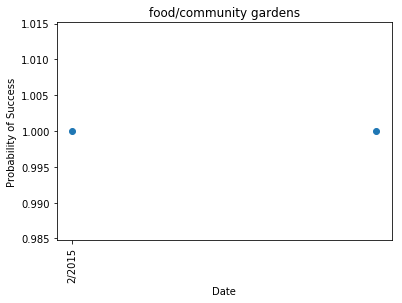

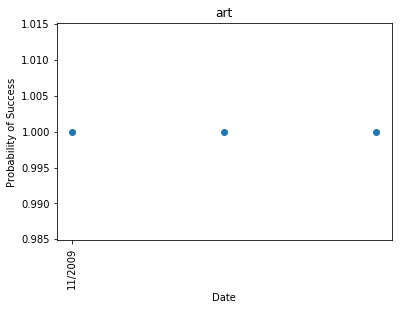

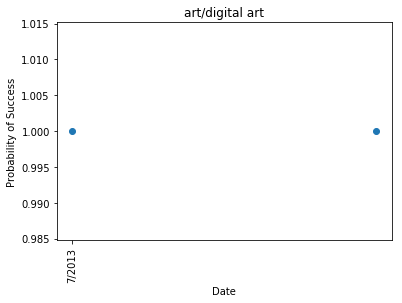

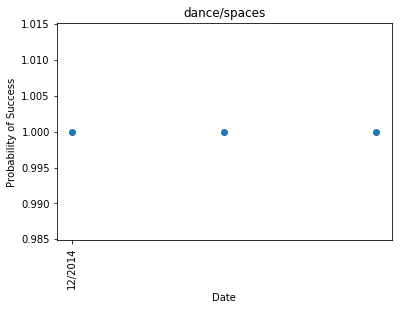

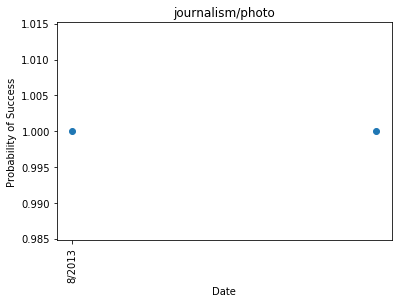

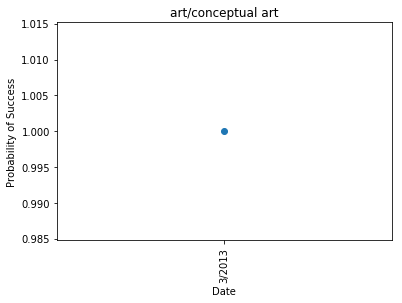

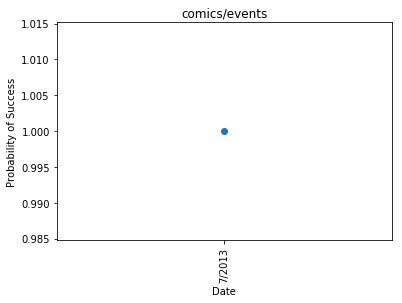

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

In [264]:
category_freq = df1['category_name'].value_counts().to_dict()

df3_1 = df1.copy()
df3_success_1 = df1_success.copy()

for i in category_freq.keys():
    temp1 = df3_1.loc[df3_1['category_name'] == i]
    temp = df3_success_1.loc[df3_success_1['category_name'] == i]
#     if i == 'design/product design':
#         print(temp1)
#         print(temp)
#         print()
    temp1['Month/Year'] = temp1['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))
    temp1 = temp1.groupby(['Month/Year']).size().to_dict()
    temp['Month/Year'] = temp['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))
    temp = temp.groupby(['Month/Year']).size().to_dict()

    ordered_df3 = sorted(temp1.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
    ordered_df3_success = sorted(temp.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)

    temp2 = []
    for k in range(len(ordered_df3)):
        if ordered_df3[k][0] in temp.keys():
            temp2.append(tuple([ordered_df3[k][0], ordered_df3[k][1]]))

    ordered_df3_success_rate = []
    for j in range(len(ordered_df3_success)):
        lst = list(ordered_df3_success[j])
        lst[1] = ordered_df3_success[j][1] / temp2[j][1]
        if lst[1] > 1:
            print(lst[0])
        ordered_df3_success_rate.append(tuple(lst))

    plt.scatter(*zip(*ordered_df3_success_rate))
    locs, labs = plt.xticks() 
    plt.xticks(locs[0::5], rotation='vertical')
    plt.xlabel('Date')
    plt.ylabel('Probability of Success')
    plt.title(i)
    plt.show()
        


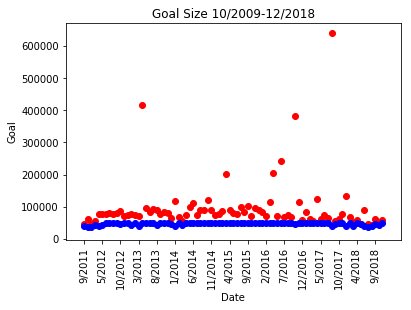

Average goal size: 
97567.92937710437
Median goal size: 
50000.0


In [200]:
df4 = df1.copy()
df4['Month/Year'] = df4['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))
new_dict = dict()
for i in df4['Month/Year']:
    temp = df4.loc[df4['Month/Year'] == i]
    new_dict[i] = temp['goal']
    
avg_dict = {}
median_dict = {}
for k,v in new_dict.items():
    avg = sum(v)/ len(v)
    if len(v) > 25: # significant enough number of projects
        avg_dict[k] = sum(v)/ len(v)
        median_dict[k] = statistics.median(v)
    
ordered_df4_1 = sorted(avg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
ordered_df4_2 = sorted(median_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)

plt.scatter(*zip(*ordered_df4_1), color = 'red')
plt.scatter(*zip(*ordered_df4_2), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation = 'vertical') 
plt.xlabel('Date')
plt.ylabel('Goal')
plt.title('Goal Size 10/2009-12/2018')
plt.show()

print('Average goal size: ')
print(sum(df4['goal']) / len(df4['goal']))
# $97,567
print('Median goal size: ')
print(statistics.median(df4['goal']))
# $50,000

/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


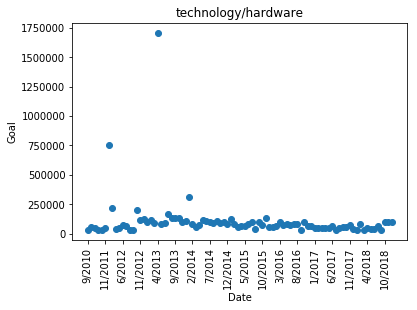

Average goal amount: 
146741.88299531981


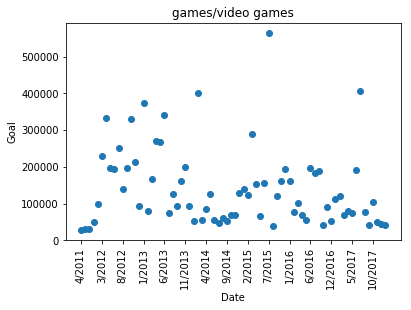

Average goal amount: 
145506.78899082568


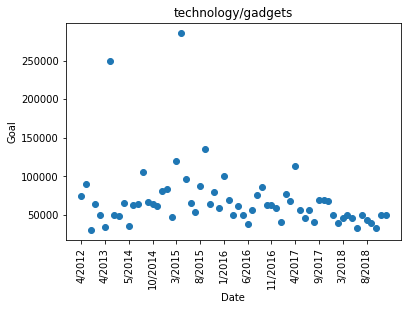

Average goal amount: 
72445.87320574162


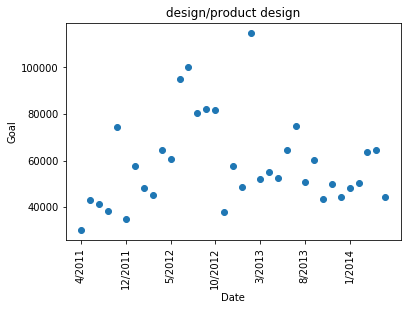

Average goal amount: 
61432.180428134554


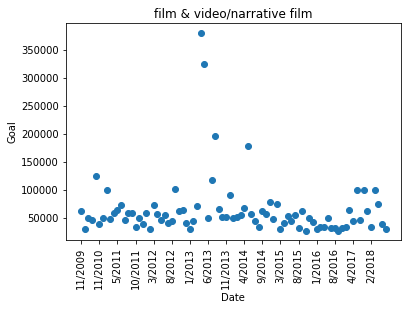

Average goal amount: 
80731.11151079136


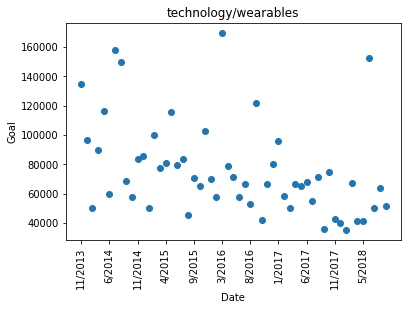

Average goal amount: 
78250.90196078431


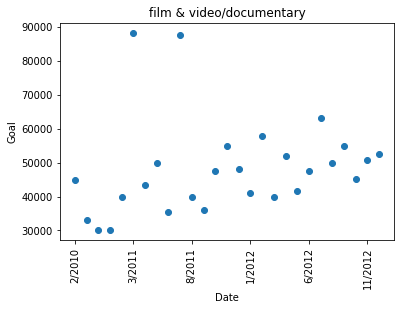

Average goal amount: 
49477.01992031872


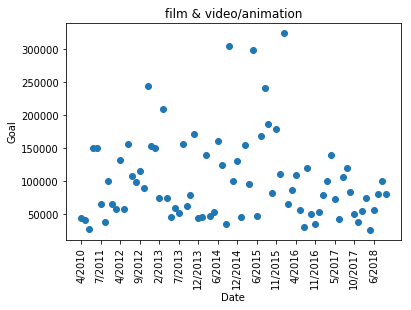

Average goal amount: 
111299.39234449761


In [216]:
category_freq = df1['category_name'].value_counts().to_dict()

df4_1 = df1.copy()

for i in category_freq.keys():
    temp = df4_1.loc[df4_1['category_name'] == i]
    if len(temp) > 200:
        temp['Month/Year'] = temp['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))
        new_dict = dict()
        for j in temp['Month/Year']:
            temp1 = temp.loc[temp['Month/Year'] == j]
            new_dict[j] = temp1['goal']

        avg_dict = {}
        for k,v in new_dict.items():
            avg_dict[k] = sum(v)/ len(v)

        ordered_df4_1 = sorted(avg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
        
        plt.scatter(*zip(*ordered_df4_1))
        locs, labs = plt.xticks() 
        plt.xticks(locs[0::5], rotation = 'vertical') 
        plt.xlabel('Date')
        plt.ylabel('Goal')
        plt.title(i)
        plt.show()
        
        print('Average goal amount: ')
        print(sum(temp['goal']) / len(temp['goal']))

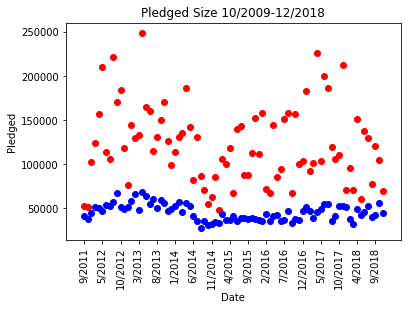

Average pledged size: 
120310.50138306126
Median pledged size: 
44131.58


In [199]:
df4 = df1.copy()
df4['Month/Year'] = df4['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))
new_dict = dict()
for i in df4['Month/Year']:
    temp = df4.loc[df4['Month/Year'] == i]
    new_dict[i] = temp['usd_pledged']
    
avg_dict = {}
median_dict = {}
for k,v in new_dict.items():
    avg = sum(v)/ len(v)
    if len(v) > 25: # significant enough number of projects
        avg_dict[k] = sum(v)/ len(v)
        median_dict[k] = statistics.median(v)
    
ordered_df4_1 = sorted(avg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
ordered_df4_2 = sorted(median_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)

plt.scatter(*zip(*ordered_df4_1), color = 'red')
plt.scatter(*zip(*ordered_df4_2), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation = 'vertical')
plt.xlabel('Date')
plt.ylabel('Pledged')
plt.title('Pledged Size 10/2009-12/2018')
plt.show()

print('Average pledged size: ')
print(sum(df4['usd_pledged']) / len(df4['usd_pledged']))
# $120,310
print('Median pledged size: ')
print(statistics.median(df4['usd_pledged']))
# $44,131

/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


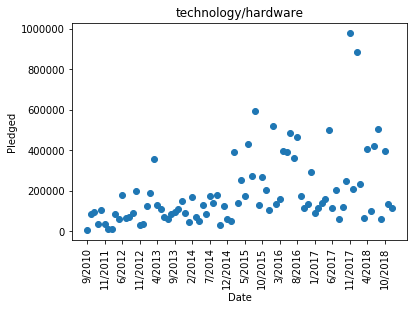

Average pledge amount: 
160687.5165054603


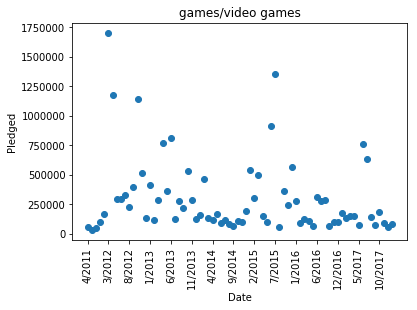

Average pledge amount: 
307489.87903669727


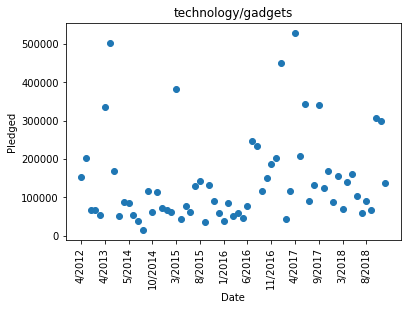

Average pledge amount: 
132838.11447368423


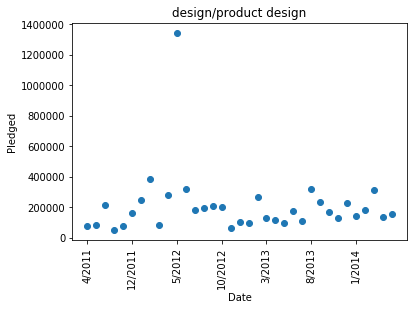

Average pledge amount: 
207949.63886850147


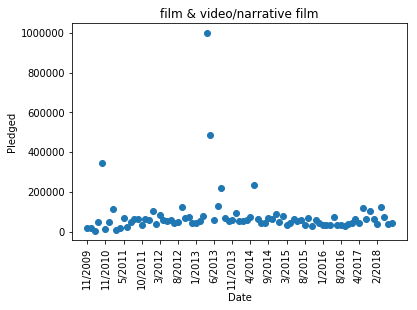

Average pledge amount: 
104587.196618705


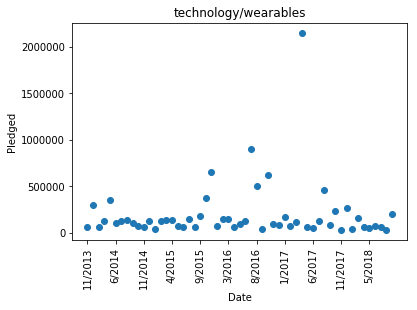

Average pledge amount: 
186993.91603921572


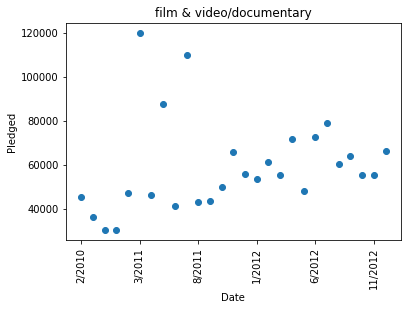

Average pledge amount: 
61764.56023904384


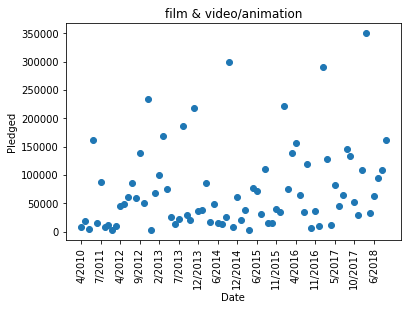

Average pledge amount: 
82688.71650717701


In [215]:
category_freq = df1['category_name'].value_counts().to_dict()

df4_1 = df1.copy()

for i in category_freq.keys():
    temp = df4_1.loc[df4_1['category_name'] == i]
    if len(temp) > 200:
        temp['Month/Year'] = temp['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))
        new_dict = dict()
        for j in temp['Month/Year']:
            temp1 = temp.loc[temp['Month/Year'] == j]
            new_dict[j] = temp1['usd_pledged']

        avg_dict = {}
        for k,v in new_dict.items():
            avg_dict[k] = sum(v)/ len(v)

        ordered_df4_1 = sorted(avg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
        
        plt.scatter(*zip(*ordered_df4_1))
        locs, labs = plt.xticks() 
        plt.xticks(locs[0::5], rotation = 'vertical') 
        plt.xlabel('Date')
        plt.ylabel('Pledged')
        plt.title(i)
        plt.show()
        
        print('Average pledge amount: ')
        print(sum(temp['usd_pledged']) / len(temp['usd_pledged']))

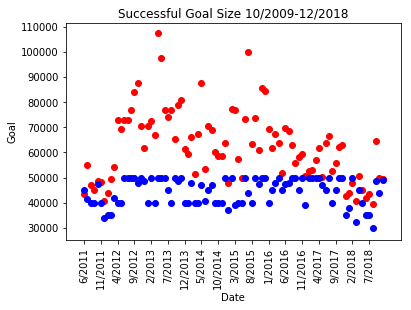

Average successful goal size: 
66087.00722700074
Median successful goal size: 
45000.0


In [198]:
df4_success = df1_success.copy()
df4_success['Month/Year'] = df4_success['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))
new_dict = dict()
for i in df4_success['Month/Year']:
    temp = df4_success.loc[df4_success['Month/Year'] == i]
    new_dict[i] = temp['goal']
    
avg_dict = {}
median_dict = {}
for k,v in new_dict.items():
    avg = sum(v)/ len(v)
    if len(v) > 15: # significant enough number of projects
        avg_dict[k] = sum(v)/ len(v)
        median_dict[k] = statistics.median(v)
    
ordered_df4_success_1 = sorted(avg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
ordered_df4_success_2 = sorted(median_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)

plt.scatter(*zip(*ordered_df4_success_1), color = 'red')
plt.scatter(*zip(*ordered_df4_success_2), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation = 'vertical') 
plt.xlabel('Date')
plt.ylabel('Goal')
plt.title('Successful Goal Size 10/2009-12/2018')
plt.show()

print('Average successful goal size: ')
print(sum(df4_success['goal']) / len(df4_success['goal']))
# $66,087
print('Median successful goal size: ')
print(statistics.median(df4_success['goal']))
# $45,000

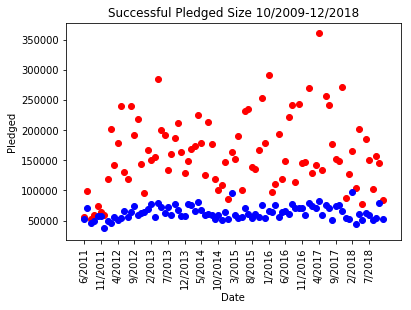

Average successful pledged size: 
166866.48235415085
Median successful pledged size: 
61685.5


In [197]:
df4_success = df1_success.copy()
df4_success['Month/Year'] = df4_success['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))
new_dict = dict()
for i in df4_success['Month/Year']:
    temp = df4_success.loc[df4_success['Month/Year'] == i]
    new_dict[i] = temp['usd_pledged']
    
avg_dict = {}
median_dict = {}
for k,v in new_dict.items():
    avg = sum(v)/ len(v)
    if len(v) > 15: # significant enough number of projects
        avg_dict[k] = sum(v)/ len(v)
        median_dict[k] = statistics.median(v)
    
ordered_df4_success_1 = sorted(avg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
ordered_df4_success_2 = sorted(median_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)

plt.scatter(*zip(*ordered_df4_success_1), color = 'red')
plt.scatter(*zip(*ordered_df4_success_2), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation = 'vertical')
plt.xlabel('Date')
plt.ylabel('Pledged')
plt.title('Successful Pledged Size 10/2009-12/2018')
plt.show()

print('Average successful pledged size: ')
print(sum(df4_success['usd_pledged']) / len(df4_success['usd_pledged']))
# $166,866
print('Median successful pledged size: ')
print(statistics.median(df4_success['usd_pledged']))
# $61,685

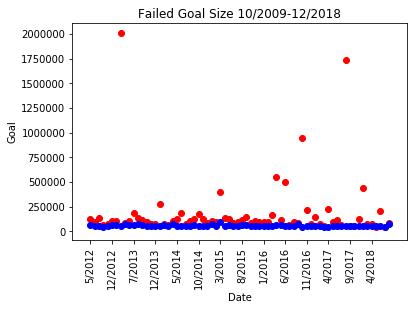

Average failed goal size: 
168486.19882055602
Median failed goal size: 
50000.0


In [195]:
df4_fail = df1_fail.copy()
df4_fail['Month/Year'] = df4_fail['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))
new_dict = dict()
for i in df4_fail['Month/Year']:
    temp = df4_fail.loc[df4_fail['Month/Year'] == i]
    new_dict[i] = temp['goal']
    
avg_dict = {}
median_dict = {}
for k,v in new_dict.items():
    avg = sum(v)/ len(v)
    if len(v) > 10: # significant enough number of projects
        avg_dict[k] = sum(v)/ len(v)
        median_dict[k] = statistics.median(v)
    
ordered_df4_fail_1 = sorted(avg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
ordered_df4_fail_2 = sorted(median_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)

plt.scatter(*zip(*ordered_df4_fail_1), color = 'red')
plt.scatter(*zip(*ordered_df4_fail_2), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation = 'vertical')
plt.xlabel('Date')
plt.ylabel('Goal')
plt.title('Failed Goal Size 10/2009-12/2018')
plt.show()

print('Average failed goal size: ')
print(sum(df4_fail['goal']) / len(df4_fail['goal']))
# $168,486
print('Median failed goal size: ')
print(statistics.median(df4_fail['goal']))
# $50,000

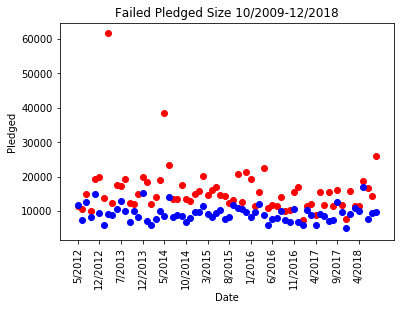

Average failed pledged size: 
15432.074157540012
Median failed pledged size: 
8769.0


In [196]:
df4_fail = df1_fail.copy()
df4_fail['Month/Year'] = df4_fail['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))
new_dict = dict()
for i in df4_fail['Month/Year']:
    temp = df4_fail.loc[df4_fail['Month/Year'] == i]
    new_dict[i] = temp['usd_pledged']
    
avg_dict = {}
median_dict = {}
for k,v in new_dict.items():
    avg = sum(v)/ len(v)
    if len(v) > 10: # significant enough number of projects
        avg_dict[k] = sum(v)/ len(v)
        median_dict[k] = statistics.median(v)
    
ordered_df4_fail_1 = sorted(avg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
ordered_df4_fail_2 = sorted(median_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)

plt.scatter(*zip(*ordered_df4_fail_1), color = 'red')
plt.scatter(*zip(*ordered_df4_fail_2), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation = 'vertical')
plt.xlabel('Date')
plt.ylabel('Pledged')
plt.title('Failed Pledged Size 10/2009-12/2018')
plt.show()

print('Average failed pledged size: ')
print(sum(df4_fail['usd_pledged']) / len(df4_fail['usd_pledged']))
# $15,432
print('Median failed pledged size: ')
print(statistics.median(df4_fail['usd_pledged']))
# $8769